<a href="https://colab.research.google.com/github/zahies/Image-Processing-CIFAR-100/blob/main/DL-CIFAR-100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install shap
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, GlobalAveragePooling2D, MaxPool2D, UpSampling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing
from pylab import rcParams
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
from numpy import expand_dims
from numpy import argmax
from sklearn.metrics import classification_report
import time





num_folds = 5
optimizer = Adam()
loss_function = sparse_categorical_crossentropy
batch_size = 32
no_epochs = 15
verbosity = 1
input_shape = (32,32,3)


In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Loading the data

In [ ]:


def unpickle(file):
    """
    unzip and load images (cifar 100)
    """
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

def read(file,data_type):
    """
    read images with rgb to train/test
    Args.
      file - file to read
      data_type - deciding to where reading the file (train/test)
    """
    filenames = [t.decode('utf8') for t in file[b'filenames']]
    if (data_type == 'test'):
      fine_labels = test[b'fine_labels']
      data = test[b'data']
    else:
      fine_labels = train[b'fine_labels']
      data = train[b'data']

    images = list()
    for d in data:
        image = np.zeros((32, 32, 3), dtype=np.uint8)
        image[..., 0] = np.reshape(d[:1024], (32, 32))  # Red channel
        image[..., 1] = np.reshape(d[1024:2048], (32, 32))  # Green channel
        image[..., 2] = np.reshape(d[2048:], (32, 32))  # Blue channel
        images.append(image)
    return filenames, fine_labels, images

path = '/content/drive/MyDrive/cifar-100-python/' # CHANGE THE PATH TO YOURS LOCATION
meta = unpickle(path + 'meta')
train = unpickle(path + 'train')
test = unpickle(path+'test')

filenames_train, fine_labels_train, images_train = read(train,'train')
filenames_test, fine_labels_test, images_test = read(test,'test')


x_train = np.array(images_train)
Y_train = np.array(fine_labels_train)
Y_train = Y_train.reshape(-1, 1)

x_test = np.array(images_test)
Y_test = np.array(fine_labels_test)
Y_test = Y_test.reshape(-1, 1)

# Question 1

data exploration

In [ ]:
print(x_train.shape[0], 'train samples')
print(Y_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [ ]:
print('Height and Width:', x_train.shape[1], "x", x_train.shape[2])
print('Channels:', x_train.shape[3])

Height and Width: 32 x 32
Channels: 3


In [ ]:
num_of_classes = len(np.unique(Y_train))
print('Number of Classes:', num_of_classes)

category = pd.DataFrame(meta[b'coarse_label_names'], columns=['SuperClass'])
subCategory = pd.DataFrame(meta[b'fine_label_names'], columns=['SubClass'])

print(category)
print(subCategory)

Number of Classes: 100
                           SuperClass
0                  b'aquatic_mammals'
1                             b'fish'
2                          b'flowers'
3                  b'food_containers'
4             b'fruit_and_vegetables'
5     b'household_electrical_devices'
6              b'household_furniture'
7                          b'insects'
8                 b'large_carnivores'
9    b'large_man-made_outdoor_things'
10    b'large_natural_outdoor_scenes'
11  b'large_omnivores_and_herbivores'
12                  b'medium_mammals'
13        b'non-insect_invertebrates'
14                          b'people'
15                        b'reptiles'
16                   b'small_mammals'
17                           b'trees'
18                      b'vehicles_1'
19                      b'vehicles_2'
            SubClass
0           b'apple'
1   b'aquarium_fish'
2            b'baby'
3            b'bear'
4          b'beaver'
..               ...
95          b'whale'
96    b'wil

**Exemple of on our augmentation technique**







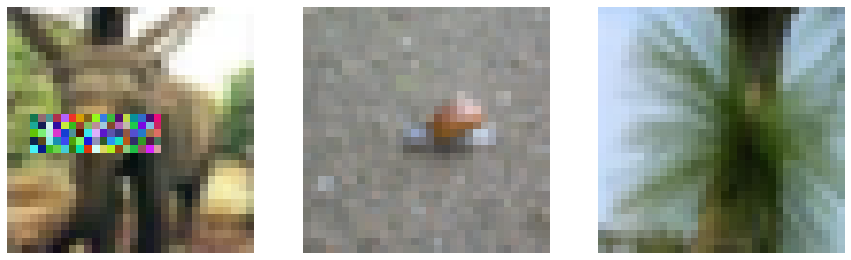

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  """
  Manual augmentation: took from site:
  https://github.com/yu4u/cutout-random-erasing
  """
  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser
# Prepere data augmentation object
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=True))
# datagen = ImageDataGenerator(brightness_range=[0.4,1.5])
datagen.fit(x_train)
# iterator
aug_iter = datagen.flow(x_train, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
# generate batch of images
for i in range(3):
	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')


In [ ]:
print('Number of labels for each category:', np.array(np.unique(Y_train, return_counts=True)).T)

Number of labels for each category: [[  0 500]
 [  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]
 [ 11 500]
 [ 12 500]
 [ 13 500]
 [ 14 500]
 [ 15 500]
 [ 16 500]
 [ 17 500]
 [ 18 500]
 [ 19 500]
 [ 20 500]
 [ 21 500]
 [ 22 500]
 [ 23 500]
 [ 24 500]
 [ 25 500]
 [ 26 500]
 [ 27 500]
 [ 28 500]
 [ 29 500]
 [ 30 500]
 [ 31 500]
 [ 32 500]
 [ 33 500]
 [ 34 500]
 [ 35 500]
 [ 36 500]
 [ 37 500]
 [ 38 500]
 [ 39 500]
 [ 40 500]
 [ 41 500]
 [ 42 500]
 [ 43 500]
 [ 44 500]
 [ 45 500]
 [ 46 500]
 [ 47 500]
 [ 48 500]
 [ 49 500]
 [ 50 500]
 [ 51 500]
 [ 52 500]
 [ 53 500]
 [ 54 500]
 [ 55 500]
 [ 56 500]
 [ 57 500]
 [ 58 500]
 [ 59 500]
 [ 60 500]
 [ 61 500]
 [ 62 500]
 [ 63 500]
 [ 64 500]
 [ 65 500]
 [ 66 500]
 [ 67 500]
 [ 68 500]
 [ 69 500]
 [ 70 500]
 [ 71 500]
 [ 72 500]
 [ 73 500]
 [ 74 500]
 [ 75 500]
 [ 76 500]
 [ 77 500]
 [ 78 500]
 [ 79 500]
 [ 80 500]
 [ 81 500]
 [ 82 500]
 [ 83 500]
 [ 84 500]
 [ 85 500]
 [ 86 500]
 [ 87 5

# Current Banchmark:
Sharpness-Aware Minimization for Efficiently Improving Generalization 96.08% using EffNet-L2 (SAM)

## Class Demonstration

Image number selected : 0
Image category number: 11
Image category name: b'Large_omnivores_and_herbivores'
Image subcategory number: 19
Image subcategory name: b'Cattle'


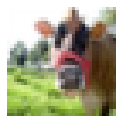

Image number selected : 1
Image category number: 15
Image category name: b'Reptiles'
Image subcategory number: 29
Image subcategory name: b'Dinosaur'


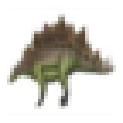

Image number selected : 2
Image category number: 4
Image category name: b'Fruit_and_vegetables'
Image subcategory number: 0
Image subcategory name: b'Apple'


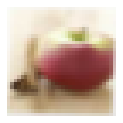

Image number selected : 3
Image category number: 14
Image category name: b'People'
Image subcategory number: 11
Image subcategory name: b'Boy'


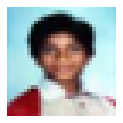

Image number selected : 4
Image category number: 1
Image category name: b'Fish'
Image subcategory number: 1
Image subcategory name: b'Aquarium_fish'


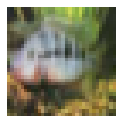

Image number selected : 5
Image category number: 5
Image category name: b'Household_electrical_devices'
Image subcategory number: 86
Image subcategory name: b'Telephone'


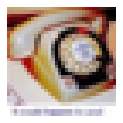

Image number selected : 6
Image category number: 18
Image category name: b'Vehicles_1'
Image subcategory number: 90
Image subcategory name: b'Train'


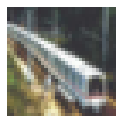

Image number selected : 7
Image category number: 3
Image category name: b'Food_containers'
Image subcategory number: 28
Image subcategory name: b'Cup'


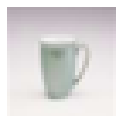

Image number selected : 8
Image category number: 10
Image category name: b'Large_natural_outdoor_scenes'
Image subcategory number: 23
Image subcategory name: b'Cloud'


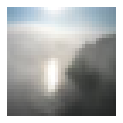

Image number selected : 11
Image category number: 17
Image category name: b'Trees'
Image subcategory number: 96
Image subcategory name: b'Willow_tree'


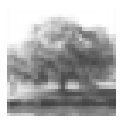

Image number selected : 12
Image category number: 2
Image category name: b'Flowers'
Image subcategory number: 82
Image subcategory name: b'Sunflower'


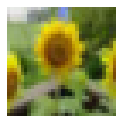

Image number selected : 13
Image category number: 9
Image category name: b'Large_man-made_outdoor_things'
Image subcategory number: 17
Image subcategory name: b'Castle'


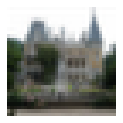

Image number selected : 17
Image category number: 8
Image category name: b'Large_carnivores'
Image subcategory number: 97
Image subcategory name: b'Wolf'


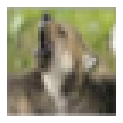

Image number selected : 18
Image category number: 16
Image category name: b'Small_mammals'
Image subcategory number: 80
Image subcategory name: b'Squirrel'


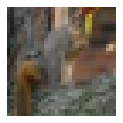

Image number selected : 25
Image category number: 6
Image category name: b'Household_furniture'
Image subcategory number: 84
Image subcategory name: b'Table'


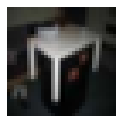

Image number selected : 26
Image category number: 12
Image category name: b'Medium_mammals'
Image subcategory number: 64
Image subcategory name: b'Possum'


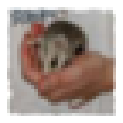

Image number selected : 36
Image category number: 19
Image category name: b'Vehicles_2'
Image subcategory number: 81
Image subcategory name: b'Streetcar'


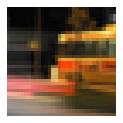

Image number selected : 38
Image category number: 7
Image category name: b'Insects'
Image subcategory number: 24
Image subcategory name: b'Cockroach'


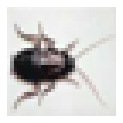

Image number selected : 41
Image category number: 13
Image category name: b'Non-insect_invertebrates'
Image subcategory number: 45
Image subcategory name: b'Lobster'


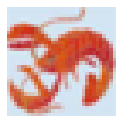

Image number selected : 61
Image category number: 0
Image category name: b'Aquatic_mammals'
Image subcategory number: 55
Image subcategory name: b'Otter'


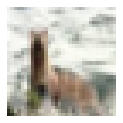

In [ ]:
list_super_classes = list(range(20))
target_ids = []
i = 0
for id in train[b'coarse_labels']:
    if id in list_super_classes:
        list_super_classes.remove(id)
        target_ids.append(i)
    if len(list_super_classes) == 0:
        break
    i += 1

#generating a random number to display a random image from the dataset along with the label's number and name
#setting the figure size
for id in target_ids:
    rcParams['figure.figsize'] = 2,2
    #generating a random number
    imageId = id
    #showing the image at that id
    plt.imshow(x_train[imageId])
    #setting display off for the image
    plt.axis('off')
    #displaying the image id
    print("Image number selected : {}".format(imageId))
    #displaying the category number
    print("Image category number: {}".format(train[b'coarse_labels'][imageId]))
    #displaying the category name
    print("Image category name: {}".format(category.iloc[train[b'coarse_labels'][imageId]][0].capitalize()))
    #displaying the subcategory number
    print("Image subcategory number: {}".format(train[b'fine_labels'][imageId]))
    #displaying the subcategory name
    print("Image subcategory name: {}".format(subCategory.iloc[train[b'fine_labels'][imageId]][0].capitalize()))

    plt.show()

# Question 2

In [ ]:
def plotting (history):
  """
  show acc and loss over the learning time
  """
  print(history.history.keys())
  #  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
 callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


def getModel():
  """
  retrn: 
    model. returns a keras model for image classification
  """
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) D
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  return model



def getModelDropout():
  """
  retrn: 
    model. returns a keras model with regularization layers for image classification
  """
  reg=None
  num_filters=32
  ac='relu'
  adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt=adm
  drop_dense=0.5
  drop_conv=0

  model = Sequential()

  model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]),padding='same'))
  model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model.add(Dropout(drop_conv))

  model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model.add(Dropout(drop_conv))

  model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model.add(Dropout(drop_conv))

  model.add(Flatten())
  model.add(Dense(512, activation=ac,kernel_regularizer=reg))
  model.add(Dropout(drop_dense))
  model.add(Dense(num_of_classes, activation='softmax'))

  model.compile(loss=loss_function, metrics=['accuracy'],optimizer=opt)

  return model


def getModelBatchNormalization(output=100):
  """
  retrn: 
    model. returns a keras model with regularization and normalization layers for image classification
  """
  reg=None
  num_filters=32
  ac='relu'
  adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt=adm
  drop_dense=0.5
  drop_conv=0

  model = Sequential()

  model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]),padding='same'))
  model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model.add(Dropout(drop_conv))

  model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model.add(Dropout(drop_conv))

  model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model.add(Dropout(drop_conv))

  model.add(Flatten())
  model.add(Dense(512, activation=ac,kernel_regularizer=reg))
  model.add(BatchNormalization())
  model.add(Dropout(drop_dense))
  model.add(Dense(output, activation='softmax'))

  model.compile(loss=loss_function, metrics=['accuracy'],optimizer=opt)

  return model



In [ ]:


def TrainModel(x_train,Y_train,x_test,Y_test,model_type,name,augm_flag=False):

  acc_per_fold = []
  loss_per_fold = []
  times = []
  best_acc = -1
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)


  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, valid in kfold.split(x_train, Y_train):
    
    # measure time for each model:
    start = time.time()
    
    
    # Compile the model
    model = model_type()
    model.compile(loss=loss_function,
                  optimizer=optimizer,
                  metrics=['accuracy'])


    # Generate a print
    print(f'--------------------------------{name}-------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    if not augm_flag:
      history = model.fit(x_train[train], Y_train[train],
                          batch_size=batch_size,
                          epochs=no_epochs,
                          validation_data=(x_train[valid], Y_train[valid]),
                          callbacks=[callback],
                          verbose=verbosity)
    else:
      history = model.fit(x_train[train], Y_train[train],
                          batch_size=batch_size,
                          epochs=no_epochs,
                          validation_data=(x_train[valid], Y_train[valid]),
                          callbacks=[callback],
                          verbose=verbosity)


      history = model.fit(datagen.flow(x_train[train], Y_train[train], batch_size=batch_size),
                          steps_per_epoch=len(x_train[train]) / batch_size, epochs=no_epochs, callbacks=[callback],
                          validation_data=(x_train[valid], Y_train[valid]))
      
    scores = model.evaluate(x_train[valid], Y_train[valid], verbose=0)

    if scores[1] > best_acc :
      best_model = model
      best_acc = scores[1]


    # Generate generalization metrics
    scores = model.evaluate(x_test, Y_test, verbose=0)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    plotting(history)


    end = time.time()
    print(f' time for fold {fold_no} : {end - start}')
    times.append(end - start)

    # Increase fold number
    fold_no = fold_no + 1


  print("Average accuracy over all folds", np.mean(acc_per_fold))
  print("Average loss over all folds", np.mean(loss_per_fold))
  print("Average Runtime over all folds", np.mean(times))

  y_pred = best_model.predict(x_test)

  return y_pred, best_model




In [ ]:

def printClassificationReport(y_pred,Y_test):
  """
  prints classification report
  Args.
    y_pred(np.array): predicted values of model
    Y_test(np.array): target values
  """
  
  predict_class = np.argmax(y_pred, axis=1)
  predict_class = predict_class.tolist()
  print(classification_report(predict_class,Y_test))

In [ ]:

def printPred(x_test,model):
  """
  show the predicted class vs the true class
  """
  img_arr = np.arange(1, 20, 1)
  image_predicted = model.predict_classes(x_test)


  for i in range(19):
    
    img = x_test[img_arr[i]]
    label = Y_test[img_arr[i]]
    plt.imshow(img)
    real_label = subCategory['SubClass'][label[0]]
    predicted_label = subCategory['SubClass'][image_predicted[img_arr[i]]]
    print('Label:', real_label, ', Predicted:', predicted_label)
    plt.show()



--------------------------------Simple-------------------------------------
Training for fold 1 ...
Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 5.1496 - accuracy: 0.0298 - val_loss: 4.0036 - val_accuracy: 0.0789
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.9246 - accuracy: 0.0926 - val_loss: 3.7936 - val_accuracy: 0.1127
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.6639 - accuracy: 0.1323 - val_loss: 3.6086 - val_accuracy: 0.1437
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.4915 - accuracy: 0.1663 - val_loss: 3.4928 - val_accuracy: 0.1714
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3763 - accuracy: 0.1856 - val_loss: 3.3880 - val_accuracy: 0.1935
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.2445 - accuracy: 0.2118 - val_loss: 3.3556 - val_accuracy: 0.2012
Epoch 7/15
1250/1250 [==============

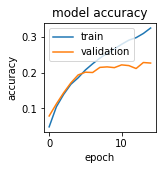

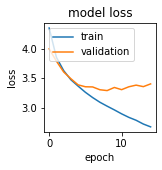

 time for fold 1 : 78.36760663986206
--------------------------------Simple-------------------------------------
Training for fold 2 ...
Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 5.0218 - accuracy: 0.0117 - val_loss: 4.5118 - val_accuracy: 0.0215
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 4.3702 - accuracy: 0.0420 - val_loss: 4.0721 - val_accuracy: 0.0735
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 4.0488 - accuracy: 0.0776 - val_loss: 3.9125 - val_accuracy: 0.1035
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.8558 - accuracy: 0.1142 - val_loss: 3.7920 - val_accuracy: 0.1193
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.6460 - accuracy: 0.1448 - val_loss: 3.6511 - val_accuracy: 0.1518
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5010 - accuracy: 0.1676 - val_loss: 3.5319 - val_accuracy: 0.1670

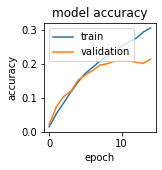

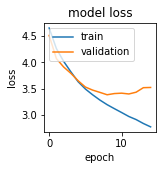

 time for fold 2 : 79.05973076820374
--------------------------------Simple-------------------------------------
Training for fold 3 ...
Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 5.0390 - accuracy: 0.0140 - val_loss: 4.2553 - val_accuracy: 0.0469
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 4.1724 - accuracy: 0.0560 - val_loss: 3.9523 - val_accuracy: 0.0900
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.9238 - accuracy: 0.0984 - val_loss: 3.8677 - val_accuracy: 0.1128
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.7335 - accuracy: 0.1277 - val_loss: 3.6871 - val_accuracy: 0.1406
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5687 - accuracy: 0.1543 - val_loss: 3.5726 - val_accuracy: 0.1604
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3863 - accuracy: 0.1871 - val_loss: 3.5114 - val_accuracy: 0.1809

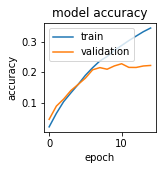

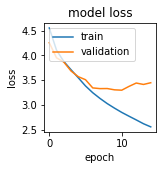

 time for fold 3 : 78.78787565231323
--------------------------------Simple-------------------------------------
Training for fold 4 ...
Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 5.0091 - accuracy: 0.0262 - val_loss: 4.0593 - val_accuracy: 0.0725
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.9699 - accuracy: 0.0851 - val_loss: 3.7573 - val_accuracy: 0.1262
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5898 - accuracy: 0.1488 - val_loss: 3.5101 - val_accuracy: 0.1630
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3457 - accuracy: 0.1926 - val_loss: 3.3697 - val_accuracy: 0.1945
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.1611 - accuracy: 0.2257 - val_loss: 3.3232 - val_accuracy: 0.2056
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.0065 - accuracy: 0.2512 - val_loss: 3.2789 - val_accuracy: 0.2230

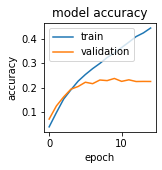

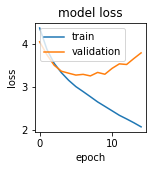

 time for fold 4 : 78.74849152565002
--------------------------------Simple-------------------------------------
Training for fold 5 ...
Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 4.9256 - accuracy: 0.0156 - val_loss: 4.1943 - val_accuracy: 0.0507
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 4.0644 - accuracy: 0.0743 - val_loss: 3.8151 - val_accuracy: 0.1144
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.7410 - accuracy: 0.1286 - val_loss: 3.6633 - val_accuracy: 0.1388
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5435 - accuracy: 0.1608 - val_loss: 3.5575 - val_accuracy: 0.1632
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3709 - accuracy: 0.1943 - val_loss: 3.4632 - val_accuracy: 0.1839
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 3.2501 - accuracy: 0.2131 - val_loss: 3.3984 - val_accuracy: 0.1922

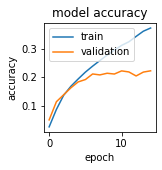

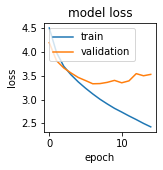

 time for fold 5 : 78.73915338516235
Average accuracy over all folds 22.33599990606308
Average loss over all folds 3.5242519855499266
Average Runtime over all folds 78.74057159423828
              precision    recall  f1-score   support

           0       0.53      0.38      0.45       138
           1       0.29      0.25      0.27       115
           2       0.32      0.09      0.14       345
           3       0.16      0.17      0.17        93
           4       0.11      0.12      0.11        92
           5       0.14      0.10      0.12       136
           6       0.20      0.19      0.19       106
           7       0.22      0.19      0.21       114
           8       0.25      0.14      0.18       180
           9       0.30      0.33      0.31        91
          10       0.05      0.10      0.07        52
          11       0.07      0.15      0.09        48
          12       0.31      0.20      0.25       152
          13       0.25      0.22      0.23       113
      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Label: b'forest' , Predicted: b'kangaroo'


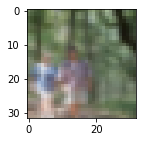

Label: b'seal' , Predicted: b'fox'


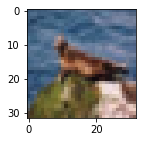

Label: b'mushroom' , Predicted: b'orchid'


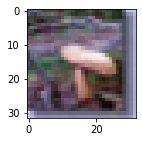

Label: b'sea' , Predicted: b'sea'


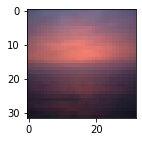

Label: b'tulip' , Predicted: b'lion'


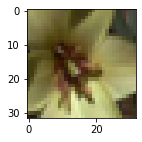

Label: b'camel' , Predicted: b'crocodile'


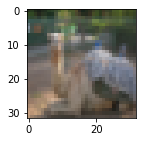

Label: b'butterfly' , Predicted: b'bear'


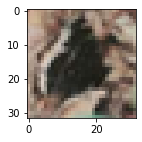

Label: b'cloud' , Predicted: b'cloud'


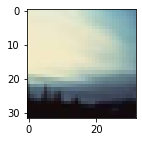

Label: b'apple' , Predicted: b'bottle'


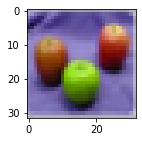

Label: b'sea' , Predicted: b'tulip'


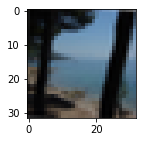

Label: b'skunk' , Predicted: b'ray'


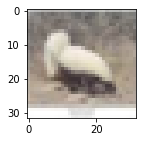

Label: b'streetcar' , Predicted: b'streetcar'


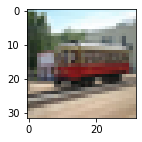

Label: b'rocket' , Predicted: b'cloud'


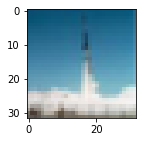

Label: b'lamp' , Predicted: b'cup'


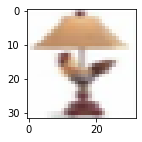

Label: b'lion' , Predicted: b'spider'


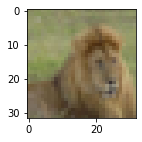

Label: b'tulip' , Predicted: b'orchid'


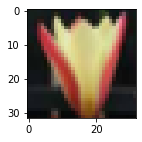

Label: b'wolf' , Predicted: b'wolf'


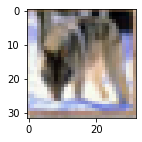

Label: b'rose' , Predicted: b'orchid'


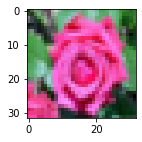

Label: b'orange' , Predicted: b'sunflower'


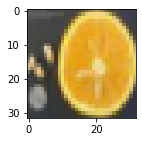

In [ ]:
y_pred, model = TrainModel(x_train,Y_train,x_test,Y_test,getModel,"Simple")

# analyze the best model from kfold:
printClassificationReport(y_pred,Y_test) 
printPred(x_test,model)

##Reasons of misclasifying & improvements metrics:

1. Overfitting - model that models the training data too well.
<br>Suggestion - Use DropOut layers that randomly cancel neuron's inputs in order to simulate a large number of networks (ensemble) and apply regularization.
2. Unnormalized data - sometimes it's hard for the model to learn with unscaled inputs, because it's hard to decide which feature has greater importance.
<br>Suggestion - use BatchNormalization which normalize its inputs.
3. Small number of observations for each category - 500 observation for each category is not eanough to train the model properly.
<br>Suggestion - Augment the images and train the model after regular training in order to increase the generalizability of the model.
4. Data noise - the images are not sharp and have blurring.
<br>Suggestion - change the contrast of images and make the edges of the objects inside the images look clearer.
5. No feature extraction - Too many features might lead to overfit.
<br>Suggestion - Apply feature extraction with the significant features (using shap package)



## 2.d

--------------------------------Dropout-------------------------------------
Training for fold 1 ...
Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 4.8346 - accuracy: 0.0078 - val_loss: 4.6071 - val_accuracy: 0.0086
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.5971 - accuracy: 0.0110 - val_loss: 4.2361 - val_accuracy: 0.0448
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.1642 - accuracy: 0.0642 - val_loss: 3.8537 - val_accuracy: 0.1142
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 3.8457 - accuracy: 0.1093 - val_loss: 3.6812 - val_accuracy: 0.1458
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 3.6687 - accuracy: 0.1382 - val_loss: 3.5228 - val_accuracy: 0.1656
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 3.5280 - accuracy: 0.1618 - val_loss: 3.4329 - val_accuracy: 0.1818
Epoch 7/15
1250/1250 [=============

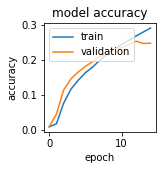

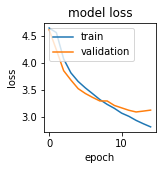

 time for fold 1 : 105.50787472724915
--------------------------------Dropout-------------------------------------
Training for fold 2 ...
Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 4.8743 - accuracy: 0.0082 - val_loss: 4.6069 - val_accuracy: 0.0086
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0103 - val_loss: 4.6073 - val_accuracy: 0.0077
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6053 - accuracy: 0.0102 - val_loss: 4.6074 - val_accuracy: 0.0077
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6053 - accuracy: 0.0104 - val_loss: 4.6075 - val_accuracy: 0.0077
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6052 - accuracy: 0.0109 - val_loss: 4.6075 - val_accuracy: 0.0077
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6053 - accuracy: 0.0095 - val_loss: 4.6075 - val_accuracy: 0.00

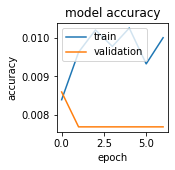

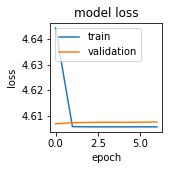

 time for fold 2 : 50.473156213760376
--------------------------------Dropout-------------------------------------
Training for fold 3 ...
Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 4.7803 - accuracy: 0.0093 - val_loss: 4.6067 - val_accuracy: 0.0080
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6056 - accuracy: 0.0094 - val_loss: 4.6056 - val_accuracy: 0.0095
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.5947 - accuracy: 0.0129 - val_loss: 4.4094 - val_accuracy: 0.0433
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.2661 - accuracy: 0.0512 - val_loss: 3.8170 - val_accuracy: 0.1202
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 3.8353 - accuracy: 0.1107 - val_loss: 3.5775 - val_accuracy: 0.1638
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 3.6211 - accuracy: 0.1502 - val_loss: 3.4203 - val_accuracy: 0.18

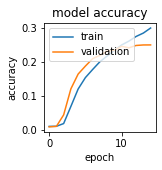

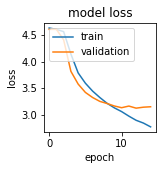

 time for fold 3 : 104.46726870536804
--------------------------------Dropout-------------------------------------
Training for fold 4 ...
Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 4.7117 - accuracy: 0.0086 - val_loss: 4.6066 - val_accuracy: 0.0081
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0099 - val_loss: 4.6069 - val_accuracy: 0.0081
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6054 - accuracy: 0.0091 - val_loss: 4.6071 - val_accuracy: 0.0081
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0103 - val_loss: 4.6073 - val_accuracy: 0.0081
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0091 - val_loss: 4.6073 - val_accuracy: 0.0081
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0103 - val_loss: 4.6074 - val_accuracy: 0.00

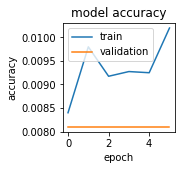

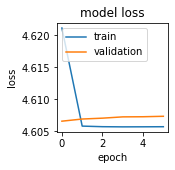

 time for fold 4 : 43.76052236557007
--------------------------------Dropout-------------------------------------
Training for fold 5 ...
Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 4.8800 - accuracy: 0.0092 - val_loss: 4.6067 - val_accuracy: 0.0076
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6056 - accuracy: 0.0086 - val_loss: 4.6073 - val_accuracy: 0.0076
Epoch 3/15
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6055 - accuracy: 0.0107 - val_loss: 4.6073 - val_accuracy: 0.0079
Epoch 4/15
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6063 - accuracy: 0.0098 - val_loss: 4.6074 - val_accuracy: 0.0083
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6054 - accuracy: 0.0110 - val_loss: 4.6075 - val_accuracy: 0.0078
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 4.6055 - accuracy: 0.0099 - val_loss: 4.6077 - val_accuracy: 0.007

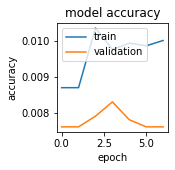

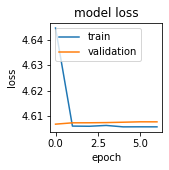

 time for fold 5 : 50.93858575820923
Average accuracy over all folds 10.610000155866146
Average loss over all folds 4.01198992729187
Average Runtime over all folds 71.02948155403138
              precision    recall  f1-score   support

           0       0.53      0.38      0.45       138
           1       0.29      0.25      0.27       115
           2       0.32      0.09      0.14       345
           3       0.16      0.17      0.17        93
           4       0.11      0.12      0.11        92
           5       0.14      0.10      0.12       136
           6       0.20      0.19      0.19       106
           7       0.22      0.19      0.21       114
           8       0.25      0.14      0.18       180
           9       0.30      0.33      0.31        91
          10       0.05      0.10      0.07        52
          11       0.07      0.15      0.09        48
          12       0.31      0.20      0.25       152
          13       0.25      0.22      0.23       113
       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Label: b'forest' , Predicted: b'kangaroo'


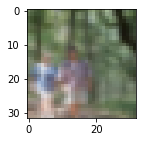

Label: b'seal' , Predicted: b'fox'


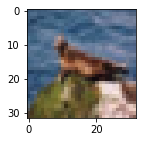

Label: b'mushroom' , Predicted: b'orchid'


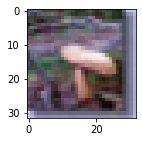

Label: b'sea' , Predicted: b'sea'


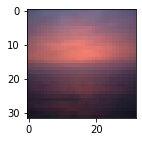

Label: b'tulip' , Predicted: b'lion'


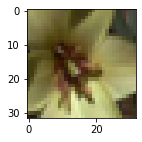

Label: b'camel' , Predicted: b'crocodile'


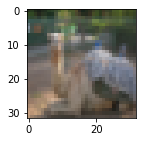

Label: b'butterfly' , Predicted: b'bear'


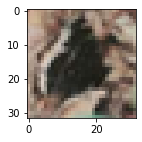

Label: b'cloud' , Predicted: b'cloud'


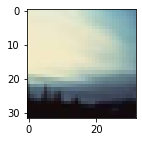

Label: b'apple' , Predicted: b'bottle'


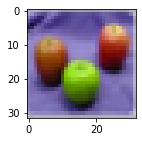

Label: b'sea' , Predicted: b'tulip'


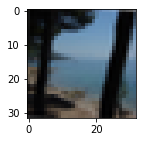

Label: b'skunk' , Predicted: b'ray'


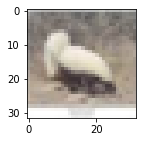

Label: b'streetcar' , Predicted: b'streetcar'


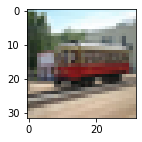

Label: b'rocket' , Predicted: b'cloud'


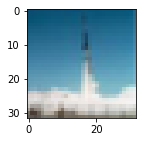

Label: b'lamp' , Predicted: b'cup'


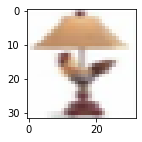

Label: b'lion' , Predicted: b'spider'


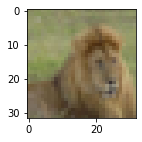

Label: b'tulip' , Predicted: b'orchid'


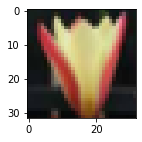

Label: b'wolf' , Predicted: b'wolf'


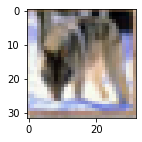

Label: b'rose' , Predicted: b'orchid'


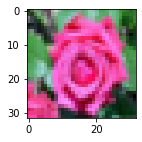

Label: b'orange' , Predicted: b'sunflower'


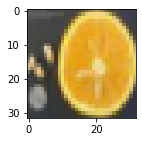

In [ ]:
# Suggestion 1 (Dropout):
# Now it's harder for the model to get fast trained on the data but with more generalizability (it's better to increase the epochs)

TrainModel(x_train,Y_train,x_test,Y_test,getModelDropout,"Dropout")
# analyze the best model from kfold:
printClassificationReport(y_pred,Y_test) 
printPred(x_test,model)



--------------------------------BatchNormalization-------------------------------------
Training for fold 1 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.6945 - accuracy: 0.0615 - val_loss: 3.4133 - val_accuracy: 0.1947
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4019 - accuracy: 0.1869 - val_loss: 2.9484 - val_accuracy: 0.2713
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9256 - accuracy: 0.2760 - val_loss: 2.6541 - val_accuracy: 0.3310
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.5412 - accuracy: 0.3512 - val_loss: 2.3469 - val_accuracy: 0.3901
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.2604 - accuracy: 0.4106 - val_loss: 2.4372 - val_accuracy: 0.3763
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0332 - accuracy: 0.4583 - val_loss: 2.1909 - val_accuracy: 0.4283
Epoch 7/15
1250/1250 [==

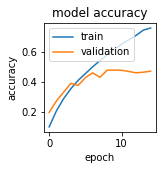

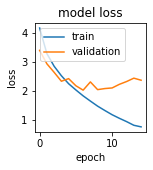

 time for fold 1 : 121.69094800949097
--------------------------------BatchNormalization-------------------------------------
Training for fold 2 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7085 - accuracy: 0.0647 - val_loss: 3.5892 - val_accuracy: 0.1648
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.3844 - accuracy: 0.1932 - val_loss: 3.0049 - val_accuracy: 0.2641
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.8174 - accuracy: 0.2992 - val_loss: 2.6495 - val_accuracy: 0.3354
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4416 - accuracy: 0.3738 - val_loss: 2.3238 - val_accuracy: 0.3939
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1455 - accuracy: 0.4315 - val_loss: 2.3262 - val_accuracy: 0.4032
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8778 - accuracy: 0.4945 - val_loss: 2.1127 - val_acc

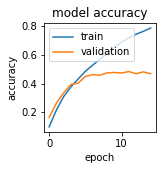

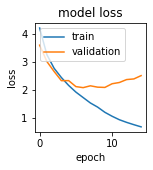

 time for fold 2 : 122.16300916671753
--------------------------------BatchNormalization-------------------------------------
Training for fold 3 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8224 - accuracy: 0.0591 - val_loss: 3.4739 - val_accuracy: 0.1793
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4264 - accuracy: 0.1827 - val_loss: 3.0359 - val_accuracy: 0.2574
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9218 - accuracy: 0.2729 - val_loss: 2.6587 - val_accuracy: 0.3332
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.5254 - accuracy: 0.3504 - val_loss: 2.3811 - val_accuracy: 0.3873
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.2111 - accuracy: 0.4174 - val_loss: 2.3013 - val_accuracy: 0.4082
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9803 - accuracy: 0.4706 - val_loss: 2.1405 - val_acc

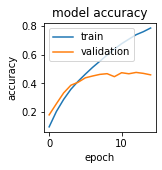

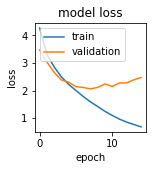

 time for fold 3 : 122.66519713401794
--------------------------------BatchNormalization-------------------------------------
Training for fold 4 ...
Epoch 1/15
1250/1250 [==============================] - 9s 6ms/step - loss: 4.6538 - accuracy: 0.0677 - val_loss: 3.5443 - val_accuracy: 0.1627
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.3183 - accuracy: 0.2032 - val_loss: 2.8034 - val_accuracy: 0.3055
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.7794 - accuracy: 0.3009 - val_loss: 2.5748 - val_accuracy: 0.3461
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.3809 - accuracy: 0.3769 - val_loss: 2.4340 - val_accuracy: 0.3793
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1133 - accuracy: 0.4435 - val_loss: 2.2134 - val_accuracy: 0.4323
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8572 - accuracy: 0.4959 - val_loss: 2.0761 - val_acc

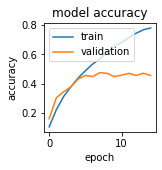

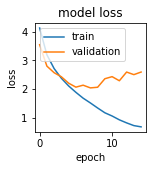

 time for fold 4 : 121.45874428749084
--------------------------------BatchNormalization-------------------------------------
Training for fold 5 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7428 - accuracy: 0.0623 - val_loss: 3.3592 - val_accuracy: 0.1954
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4035 - accuracy: 0.1887 - val_loss: 3.5176 - val_accuracy: 0.1902
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.8724 - accuracy: 0.2847 - val_loss: 2.6633 - val_accuracy: 0.3358
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4971 - accuracy: 0.3558 - val_loss: 2.5286 - val_accuracy: 0.3623
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1731 - accuracy: 0.4231 - val_loss: 2.2307 - val_accuracy: 0.4244
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9251 - accuracy: 0.4805 - val_loss: 2.1886 - val_acc

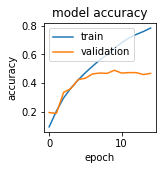

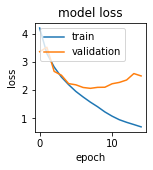

 time for fold 5 : 124.00980281829834
Average accuracy over all folds 47.38200008869171
Average loss over all folds 2.4615571022033693
Average Runtime over all folds 122.39754028320313
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       100
           1       0.63      0.59      0.61       106
           2       0.31      0.29      0.30       107
           3       0.32      0.25      0.28       126
           4       0.32      0.32      0.32        99
           5       0.41      0.51      0.45        81
           6       0.49      0.46      0.48       106
           7       0.60      0.37      0.45       164
           8       0.62      0.70      0.66        89
           9       0.63      0.58      0.61       108
          10       0.30      0.39      0.34        76
          11       0.27      0.44      0.34        61
          12       0.59      0.51      0.55       115
          13       0.35      0.58      0.44        60
    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Label: b'forest' , Predicted: b'forest'


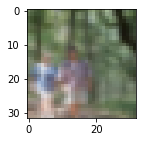

Label: b'seal' , Predicted: b'dolphin'


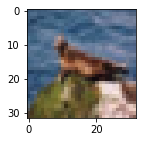

Label: b'mushroom' , Predicted: b'raccoon'


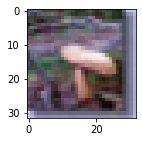

Label: b'sea' , Predicted: b'sea'


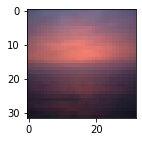

Label: b'tulip' , Predicted: b'spider'


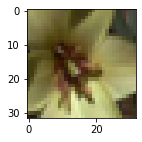

Label: b'camel' , Predicted: b'crocodile'


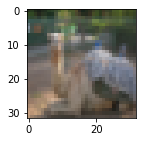

Label: b'butterfly' , Predicted: b'shrew'


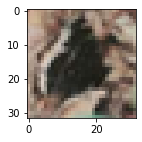

Label: b'cloud' , Predicted: b'cloud'


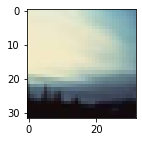

Label: b'apple' , Predicted: b'apple'


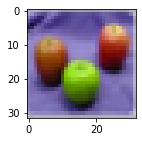

Label: b'sea' , Predicted: b'television'


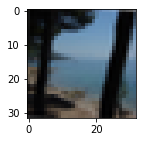

Label: b'skunk' , Predicted: b'skunk'


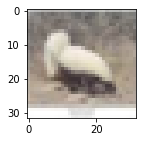

Label: b'streetcar' , Predicted: b'streetcar'


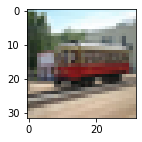

Label: b'rocket' , Predicted: b'rocket'


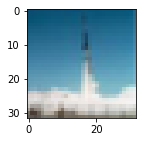

Label: b'lamp' , Predicted: b'lamp'


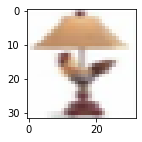

Label: b'lion' , Predicted: b'lion'


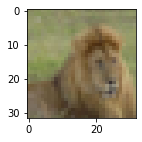

Label: b'tulip' , Predicted: b'tulip'


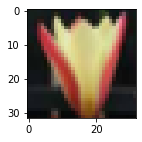

Label: b'wolf' , Predicted: b'possum'


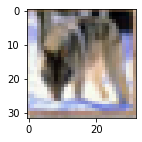

Label: b'rose' , Predicted: b'rose'


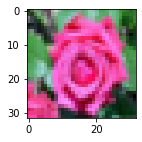

Label: b'orange' , Predicted: b'orange'


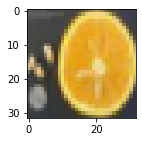

In [ ]:
# # Suggestion 2 (BatchNormalization):

y_pred, model = TrainModel(x_train,Y_train,x_test,Y_test,getModelBatchNormalization,"BatchNormalization")
# analyze the best model from kfold:
printClassificationReport(y_pred,Y_test) 
printPred(x_test,model)


--------------------------------Augmentation-------------------------------------
Training for fold 1 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8177 - accuracy: 0.0583 - val_loss: 3.6236 - val_accuracy: 0.1653
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.5047 - accuracy: 0.1753 - val_loss: 2.9166 - val_accuracy: 0.2785
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9105 - accuracy: 0.2771 - val_loss: 2.5854 - val_accuracy: 0.3398
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4858 - accuracy: 0.3639 - val_loss: 2.4178 - val_accuracy: 0.3846
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1946 - accuracy: 0.4221 - val_loss: 2.2349 - val_accuracy: 0.4151
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9551 - accuracy: 0.4751 - val_loss: 2.1465 - val_accuracy: 0.4425
Epoch 7/15
1250/1250 [========

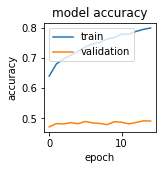

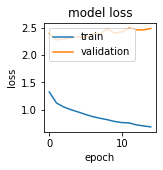

 time for fold 1 : 281.97960019111633
--------------------------------Augmentation-------------------------------------
Training for fold 2 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7680 - accuracy: 0.0634 - val_loss: 3.5556 - val_accuracy: 0.1692
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4153 - accuracy: 0.1839 - val_loss: 3.1529 - val_accuracy: 0.2360
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.8816 - accuracy: 0.2827 - val_loss: 2.5995 - val_accuracy: 0.3389
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.5205 - accuracy: 0.3547 - val_loss: 2.3468 - val_accuracy: 0.3905
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1885 - accuracy: 0.4272 - val_loss: 2.2414 - val_accuracy: 0.4107
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9425 - accuracy: 0.4798 - val_loss: 2.1436 - val_accuracy:

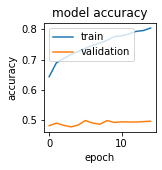

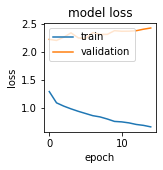

 time for fold 2 : 283.2657480239868
--------------------------------Augmentation-------------------------------------
Training for fold 3 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8455 - accuracy: 0.0588 - val_loss: 3.8990 - val_accuracy: 0.1129
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.4538 - accuracy: 0.1812 - val_loss: 3.1031 - val_accuracy: 0.2519
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.8920 - accuracy: 0.2825 - val_loss: 2.5420 - val_accuracy: 0.3578
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4800 - accuracy: 0.3624 - val_loss: 2.4750 - val_accuracy: 0.3726
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1974 - accuracy: 0.4212 - val_loss: 2.3068 - val_accuracy: 0.4042
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9649 - accuracy: 0.4714 - val_loss: 2.2273 - val_accuracy: 

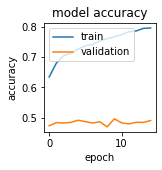

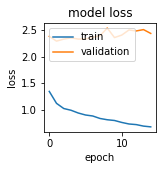

 time for fold 3 : 279.75321316719055
--------------------------------Augmentation-------------------------------------
Training for fold 4 ...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 4.6818 - accuracy: 0.0688 - val_loss: 3.7364 - val_accuracy: 0.1439
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 3.3733 - accuracy: 0.1940 - val_loss: 2.9593 - val_accuracy: 0.2744
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.7924 - accuracy: 0.2979 - val_loss: 2.8690 - val_accuracy: 0.2913
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4142 - accuracy: 0.3779 - val_loss: 2.8078 - val_accuracy: 0.3238
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1416 - accuracy: 0.4332 - val_loss: 2.1504 - val_accuracy: 0.4389
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8764 - accuracy: 0.4993 - val_loss: 2.0598 - val_accuracy:

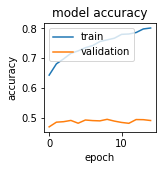

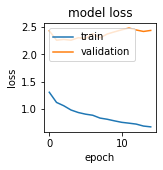

 time for fold 4 : 282.85098600387573
--------------------------------Augmentation-------------------------------------
Training for fold 5 ...
Epoch 1/15
1250/1250 [==============================] - 10s 7ms/step - loss: 4.7464 - accuracy: 0.0642 - val_loss: 3.3680 - val_accuracy: 0.1961
Epoch 2/15
1250/1250 [==============================] - 8s 7ms/step - loss: 3.4182 - accuracy: 0.1880 - val_loss: 3.1234 - val_accuracy: 0.2384
Epoch 3/15
1250/1250 [==============================] - 8s 7ms/step - loss: 2.9142 - accuracy: 0.2804 - val_loss: 2.6404 - val_accuracy: 0.3334
Epoch 4/15
1250/1250 [==============================] - 8s 7ms/step - loss: 2.5039 - accuracy: 0.3599 - val_loss: 2.3920 - val_accuracy: 0.3814
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1901 - accuracy: 0.4234 - val_loss: 2.4309 - val_accuracy: 0.3804
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9274 - accuracy: 0.4823 - val_loss: 2.2159 - val_accuracy

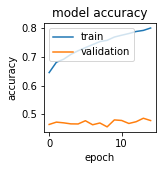

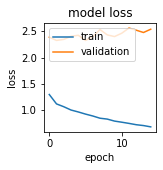

 time for fold 5 : 286.14856123924255
Average accuracy over all folds 49.47999954223633
Average loss over all folds 2.442529630661011
Average Runtime over all folds 282.7996217250824
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       116
           1       0.54      0.68      0.60        80
           2       0.26      0.37      0.30        71
           3       0.13      0.30      0.18        44
           4       0.27      0.29      0.28        92
           5       0.41      0.44      0.42        94
           6       0.51      0.49      0.50       105
           7       0.55      0.54      0.55       101
           8       0.63      0.61      0.62       104
           9       0.68      0.59      0.63       116
          10       0.38      0.38      0.38       101
          11       0.36      0.29      0.32       125
          12       0.56      0.57      0.56        99
          13       0.48      0.42      0.45       114
      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Label: b'forest' , Predicted: b'forest'


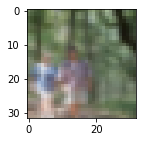

Label: b'seal' , Predicted: b'beaver'


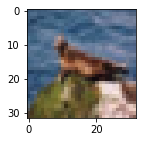

Label: b'mushroom' , Predicted: b'bus'


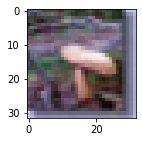

Label: b'sea' , Predicted: b'sea'


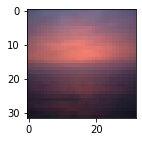

Label: b'tulip' , Predicted: b'spider'


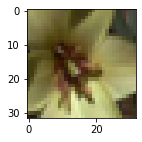

Label: b'camel' , Predicted: b'kangaroo'


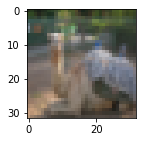

Label: b'butterfly' , Predicted: b'shrew'


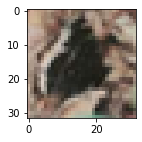

Label: b'cloud' , Predicted: b'cloud'


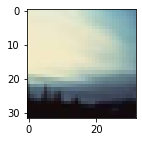

Label: b'apple' , Predicted: b'apple'


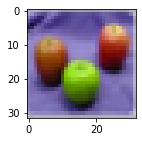

Label: b'sea' , Predicted: b'television'


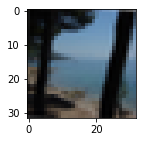

Label: b'skunk' , Predicted: b'skunk'


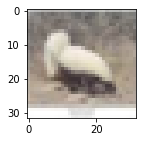

Label: b'streetcar' , Predicted: b'streetcar'


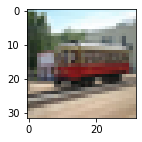

Label: b'rocket' , Predicted: b'rocket'


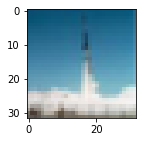

Label: b'lamp' , Predicted: b'lamp'


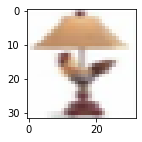

Label: b'lion' , Predicted: b'lion'


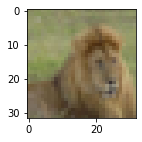

Label: b'tulip' , Predicted: b'tulip'


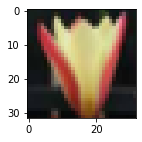

Label: b'wolf' , Predicted: b'kangaroo'


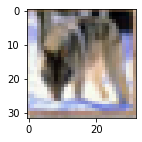

Label: b'rose' , Predicted: b'rose'


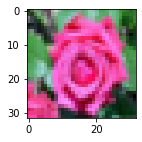

Label: b'orange' , Predicted: b'orange'


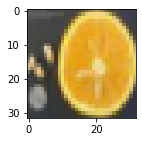

In [ ]:

# Suggestion 3 (Augmentation):
# continuing the fit with augmented images to increase the generalizability of the model


y_pred, model = TrainModel(x_train,Y_train,x_test,Y_test,getModelBatchNormalization,"Augmentation",augm_flag=True)
# analyze the best model from kfold:
printClassificationReport(y_pred,Y_test) 
printPred(x_test,model)

# 2.e:

In [ ]:

# inference phase using test-time augmentation
def tesTimeA_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	dataSet = expand_dims(image, 0)
	# prepare iterator
	it_datagen = datagen.flow(dataSet, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict(it_datagen, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	return argmax(summed)
 

# evaluate a model on a dataset using test-time augmentation
def tesTimeA_evaluate_model(model, testX, testY):
    # configure image data augmentation
    datagen = ImageDataGenerator(horizontal_flip=True)
    # define the number of augmented images to generate per test set image
    num_examples_per_image = 1
    yhats = list()
    for i in range(len(testX)):
      # make augmented prediction
      yhat = tesTimeA_prediction(datagen, model, testX[i], num_examples_per_image)
      # store for evaluation
      yhats.append(yhat)
    # calculate accuracy
    testY_labels = argmax(testY, axis=1)
    acc = accuracy_score(testY_labels, yhats)
    print("accuracy of the model on augmented test images: ", acc)
    
 
tesTimeA_evaluate_model(model_trans,x_test,Y_test)

accuracy of the model on augmented test images:  0.6585


# Question 3 (a,b,c)


(10000, 100)
(10000, 100)
94773248/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
625/625 [==============================] - 214s 333ms/step - loss: 3.2571 - accuracy: 0.2475 - val_loss: 1.4327 - val_accuracy: 0.5960
Epoch 2/10
625/625 [==============================] - 206s 330ms/step - loss: 1.5597 - accuracy: 0.5696 - val_loss: 1.0584 - val_accuracy: 0.6872
Epoch 3/10
625/625 [==============================] - 206s 330ms/step - loss: 1.2455 - accuracy: 0.6462 - val_loss: 0.9386 - val_accuracy: 0.7194
Epoch 4/10
625/625 [==============================] - 206s 330ms/step - loss: 1.0940 - accuracy: 0.6844 - val_loss: 0.8866 - val_accuracy: 0.7338
Epoch 5/10
625/625 [==============================] - 206s 330ms/step - loss: 0.9946 - accuracy: 0.7066 - val_loss: 0.8779 - val_accuracy: 0.7423
Epoch 6/10
625/625 [==============================] - 206s 330ms/step - loss: 0.9133 - accuracy: 0.7281 - val_loss: 0.8426 - val_accuracy: 0.7481
Epoch 7/10
625/625 [==============================] - 206s 330ms/step - loss: 0.8481 - accuracy: 0.7470 - val_loss: 0.8274 -

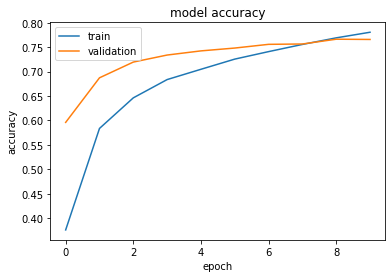

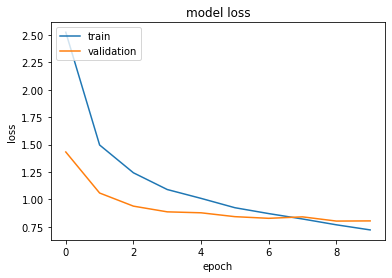

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       103
           1       0.85      0.79      0.82       107
           2       0.79      0.51      0.62       154
           3       0.63      0.66      0.65        95
           4       0.65      0.52      0.58       125
           5       0.78      0.77      0.78       101
           6       0.85      0.71      0.78       119
           7       0.82      0.75      0.78       109
           8       0.90      0.91      0.90        99
           9       0.90      0.92      0.91        98
          10       0.61      0.64      0.63        95
          11       0.40      0.56      0.47        71
          12       0.77      0.93      0.84        83
          13       0.73      0.81      0.77        90
          14       0.70      0.90      0.79        78
          15       0.84      0.73      0.78       115
          16       0.83      0.84      0.83        99
          17       0.90    

In [ ]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# import tensorflow.keras.applications.Xception as Xception 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split

def getPreTrainedModel():
  model = Sequential()
  model.add(UpSampling2D())
  model.add(UpSampling2D())
  model.add(UpSampling2D())
  model.add(resnet_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))
  return model

(x_train, Y_train), (x_test, Y_test) = tf.keras.datasets.cifar100.load_data(
    label_mode='fine'
)

x_train, x_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size=0.2, random_state=42)


# measure time for each model:
start = time.time()


num_classes = 100
num_epochs = 10
batch_size = 64

Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_val = np_utils.to_categorical(Y_val, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

print(Y_val.shape)
print(Y_test.shape)
resnet_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


# freeze layers (only BatchNormalization layers):
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False



model_trans = getPreTrainedModel()
model_trans.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model_trans.fit_generator(datagen.flow(x_train, Y_train,
                                  batch_size=batch_size),
                                  epochs=num_epochs,
                                  validation_data=(x_val, Y_val))


end = time.time()
print(f' time for pretrained model to train: {end - start}')

# Generate generalization metrics
scores = model_trans.evaluate(x_test, Y_test, verbose=0)

print(f'Score : {model_trans.metrics_names[0]} of {scores[0]}; {model_trans.metrics_names[1]} of {scores[1]*100}%')
plotting(history)



y_pred = model_trans.predict(x_test)

predict_class = np.argmax(Y_test, axis=1)
predict_class = predict_class.tolist()

# analyze the best model from kfold:
printClassificationReport(y_pred,predict_class) 









# Question 3 (d)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report


extract = Model(model_trans.inputs, model_trans.layers[-2].output)
features = extract.predict(x_train)
features_test = extract.predict(x_test)

# Generate a print
print('------------------------------RandomForestClassifier--------------------------------')

clf=RandomForestClassifier(n_estimators=70)


# measure time to train model:
start = time.time()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(features,Y_train)  

end = time.time()
print(f' time for pretrained model to train: {end - start}')

y_pred=clf.predict(features_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))





------------------------------RandomForestClassifier--------------------------------
Accuracy: 0.2766
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       100
           1       0.97      0.29      0.45       100
           2       0.88      0.21      0.34       100
           3       1.00      0.07      0.13       100
           4       0.00      0.00      0.00       100
           5       0.93      0.26      0.41       100
           6       1.00      0.13      0.23       100
           7       1.00      0.23      0.37       100
           8       0.98      0.63      0.77       100
           9       0.98      0.51      0.67       100
          10       1.00      0.15      0.26       100
          11       1.00      0.05      0.10       100
          12       1.00      0.20      0.33       100
          13       0.97      0.34      0.50       100
          14       1.00      0.09      0.17       100
          15       1.00      0.33

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results:



| Assignment | Description | test_loss | tr_loss | Runtime | batch_size | acc_test | acc_train |
| :- | :-: |:-- | :-- | :-: |:-: | :-: |:-: |
| Initial Model | Simple model with a few conv layers and max pooling | 3.44 | 2.44  | 79 Sec |  32 |.24 | .35 |
| Dropout Model | A model with some dropout layers in order to regulate from overfitting | 3.03 | 2.68  | 112 Sec |  32 |.26 | .31 |
| BatchNorm Model | A model with some dropout, batchNormalization and more deeper layers | 2.48 | 0.66  | 129 Sec |  32 |.48 | .79 |
| Augmentation Model | A model trained over train data and over the augmented data in order to increase the generabillity | 2.44 | 0.66  | 293 Sec |  32 |.50 | .80 |
| Pretrained Model | A model that includes resNet model with fixed weights | 0.82 | 0.70  | 2074 Sec |  64 |.76 | .78 |
| RandomForest Model | A model that uses the last model (Pretrained) as feature generator | - | -  | 158 Sec |  - |.28 | .37 |